**1) Realiza todo el preprocesamiento necesario. Elimina aquellos datos que sean muy dependientes de otros y transforma en categóricos con 3 valores los que miden el área, el diámetro y la compacidad.**

Para realizar este primer ejercicio, hacemos una exploración previa del dataset, donde a priori, podemos ver que la última columna está vacía.
Queremos estudiar la dependencia entre las variables, para valorar aquellas que queremos eliminar, para ello, creamos una matriz de correlación y buscamos aquellos valores con una correlación mayor que 0.95 para así eliminarlos.

Por otro lado, vamos a transformar en categóricos con 3 valores los que miden el área, el diámetro y la compacidad

In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.tree import export_graphviz
import matplotlib.pyplot as plt
from sklearn import tree
import graphviz

df = pd.read_csv('cancer.csv')

# Exploración del dataset
#print(df.describe())
#print(df.info())

# Eliminar las columnas que contengan Na y el id
df = df.iloc[:, 1:]
df = df.dropna(axis=1)

# MATRIZ DE CORRELACIÓN
column_diag = [df.columns[0]]
column_corr = df.columns.difference(column_diag)
matrizCorrelacion = df[column_corr].corr().abs()
# Seleccionamos la triangular superior
upper = matrizCorrelacion.where(np.triu(np.ones(matrizCorrelacion.shape), k=1).astype(bool))
# Eliminar índices mayores de 0.95
mas95 = [column for column in upper.columns if any(upper[column] > 0.95)]
df = df.drop(mas95, axis=1)

# Función para categorizar basado en percentiles
def categorize_column(column, bin_edges):
    labels = ["Bajo", "Medio", "Alto"]
    return pd.cut(column, bins=bin_edges, labels=labels, include_lowest=True)

# Categorizar 'area_mean', 'perimeter_mean', y 'compactness_mean'
for feature in ['area_mean', 'compactness_mean']:
    bin_edges = df[feature].quantile([0, 0.33, 0.66, 1]).values
    df[feature + '_cat'] = categorize_column(df[feature], bin_edges)

print(df.head())

  diagnosis  texture_mean  area_mean  smoothness_mean  compactness_mean  \
0         M         10.38     1001.0          0.11840           0.27760   
1         M         17.77     1326.0          0.08474           0.07864   
2         M         21.25     1203.0          0.10960           0.15990   
3         M         20.38      386.1          0.14250           0.28390   
4         M         14.34     1297.0          0.10030           0.13280   

   concavity_mean  concave points_mean  symmetry_mean  fractal_dimension_mean  \
0          0.3001              0.14710         0.2419                 0.07871   
1          0.0869              0.07017         0.1812                 0.05667   
2          0.1974              0.12790         0.2069                 0.05999   
3          0.2414              0.10520         0.2597                 0.09744   
4          0.1980              0.10430         0.1809                 0.05883   

   texture_se  ...  fractal_dimension_se  texture_worst  smoot

**2) Crea los distintos clasificadores en el que utilices al menos dos criterios de división distintos o medidas de desorden. Calcula el error en cada uno de ellos y elige el qué mejor clasifique.**

Primero fragmentamos nuestra base de datos en tres segmentos: uno para instruir nuestros modelos (el grupo de instrucción), otro para examinar su desempeño (el grupo de evaluación) y otro que utilizaremos posteriormente en el apartado número 5. Esta tarea implica desglosar las características (X) de la etiqueta que buscamos predecir ('diagnóstico'), asignando el 10% de los datos al grupo de prueba y destinando el restante al grupo de entrenamiento y evalución (72% del total y 18% del total respectivamente).

Posteriormente, adiestramos un clasificador de bosque aleatorio utilizando el criterio de entropía y de gini para valorar la idoneidad de las particiones. Una vez adiestrado el clasificador, escogemos uno de los árboles generados para su visualización.

In [3]:
# Convertir 'diagnosis' a valores numéricos
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Convertir de categóricas a numéricas
df = pd.get_dummies(df, drop_first=True)

# Definir variables predictoras y objetivo
X = df.drop("diagnosis", axis=1)
y = df['diagnosis']

# Dividir el conjunto de datos en prueba y el resto
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=40)

# Dividir el resto en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# CLASIFICADORES CON DIFERENTES CRITERIOS
criterios = ['gini', 'entropy']
clasificadores = {}
errores = {}

for criterio in criterios:
    # Crear y entrenar el clasificador con el criterio actual
    clf = RandomForestClassifier(random_state=42, criterion=criterio)
    clf.fit(X_train, y_train)

    # Realizar predicciones con el conjunto de prueba
    y_pred = clf.predict(X_test)

    # Calcular la precisión
    precision = accuracy_score(y_test, y_pred)

    # Calcular el error de clasificación
    error = 1 - precision

    # Guardar el error y el clasificador en los diccionarios
    errores[criterio] = error
    clasificadores[criterio] = clf

    # Mostrar los resultados
    print(f"Resultados para el criterio '{criterio}':")
    print(f"Error de clasificación: {error}\n")

# Seleccionar el mejor clasificador basado en el menor error de clasificación
mejor_criterio = min(errores, key=errores.get)
mejor_clasificador = clasificadores[mejor_criterio]
mejor_error = errores[mejor_criterio]

# Mostrar el mejor clasificador y su error
print(f"El mejor clasificador es con el criterio '{mejor_criterio}' con un error de clasificación de {mejor_error}.")

Resultados para el criterio 'gini':
Error de clasificación: 0.01754385964912286

Resultados para el criterio 'entropy':
Error de clasificación: 0.01754385964912286

El mejor clasificador es con el criterio 'gini' con un error de clasificación de 0.01754385964912286.


Si comparamos losvalores obtenidos para cada uno de los criterios, podemos observar que son exactamente iguales, sin embargo, utilizando el comando de 'max' nos devuelve que el mejor método el gini, por lo tanto escogeremos este, obtendremos los mismos resultados.

**3) Dibuja los modelos elegidos en el punto anterior.**

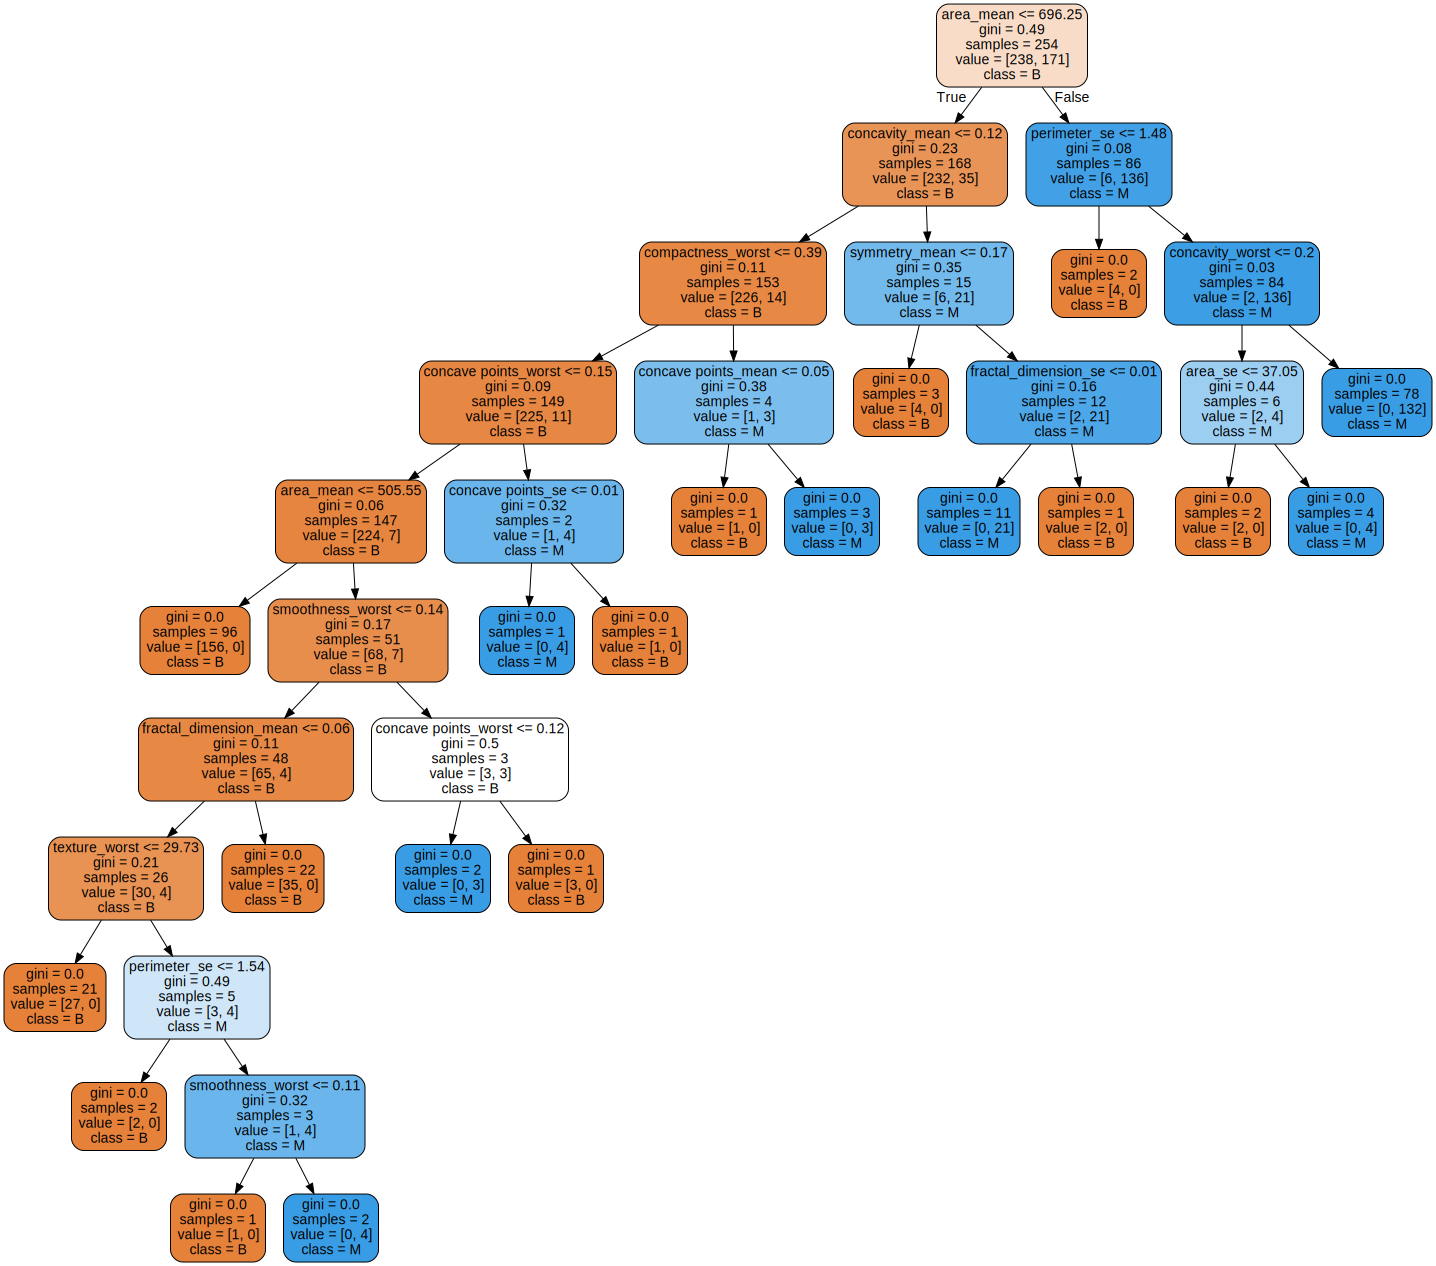

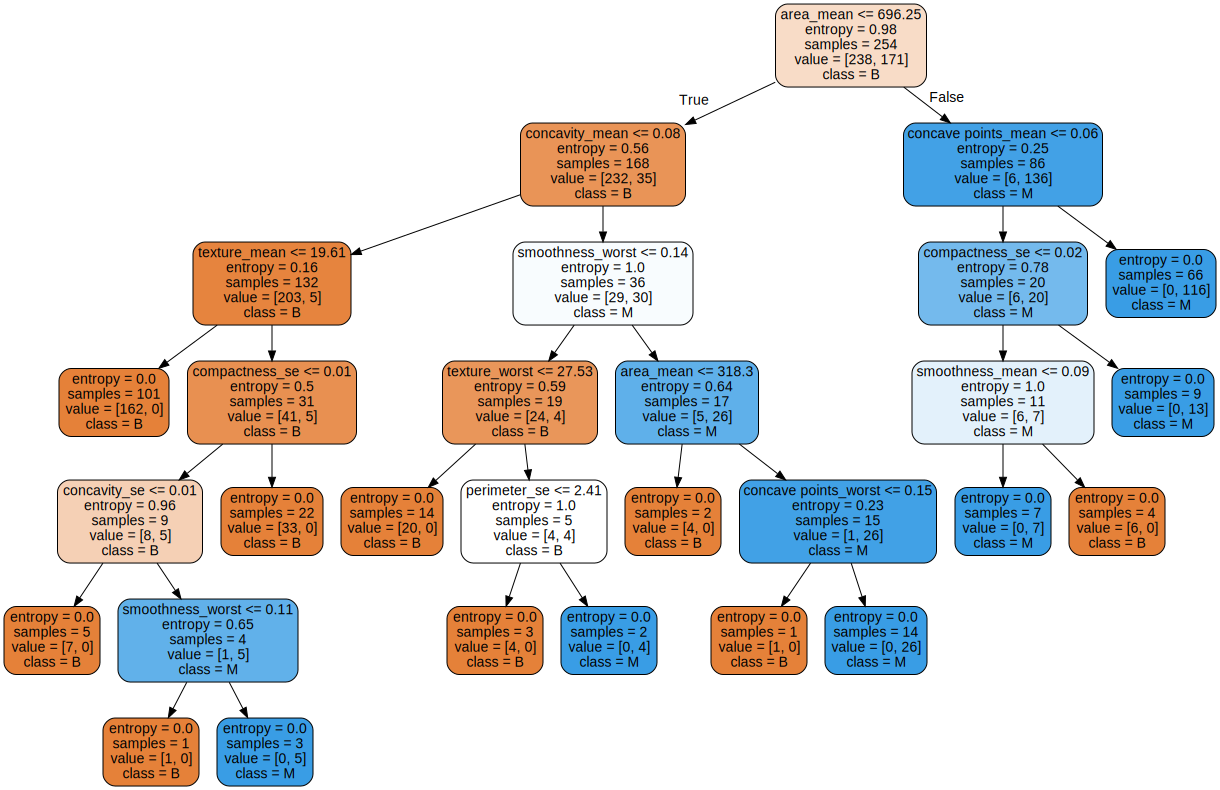

In [4]:
for criterio, clf in clasificadores.items():
    # Tomamos un único árbol del bosque para la visualización
    single_tree = clf.estimators_[0]

    # Exportamos ese árbol a un formato de archivo Dot
    dot_data = export_graphviz(
        single_tree,
        out_file=None,
        feature_names=X.columns,
        class_names=['B', 'M'],
        rounded=True,
        proportion=False,
        precision=2,
        filled=True,
    )

    graph = graphviz.Source(dot_data)
    display(graph)

Una vez representados ambos árboles, podemos observar que con el criterio de gini, obtenemos un árbol con un menor número de ramas por lo que realiza una clasificación más directa.

**4) Selecciona dos reglas que sean las que generalicen lo menos posible y otras dos que especialicen lo menos posible. Interprétalas. Si la estructura obtenida para sacar las reglas es demasiado grande repite el proceso para un 10% de los datos.**

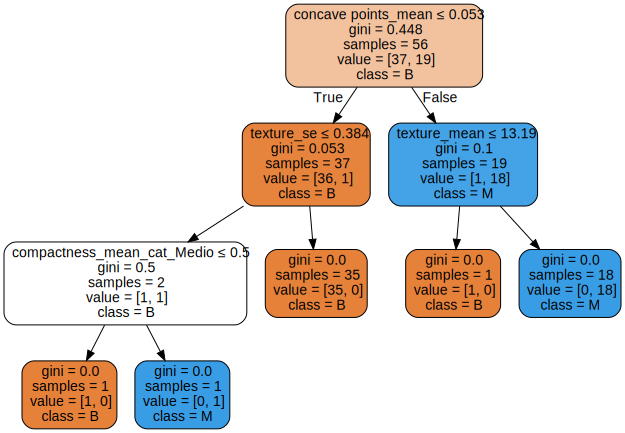

In [5]:
# Reducir el dataset un 10% de su tamaño original
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.9, random_state=42)

# Entrenar un nuevo árbol de decisión con el dataset reducido
clf_small = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=3)
clf_small.fit(X_small, y_small)

# Visualizar el árbol
dot_data = export_graphviz(
    clf_small,
    out_file=None,
    feature_names=X.columns,
    class_names=['B', 'M'],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3
)
graph = graphviz.Source(dot_data)
display(graph)

El árbol de decisión visualizado muestra cómo se pueden clasificar las muestras en dos categorías utilizando características específicas. La raíz del árbol utiliza la característica 'concave points_mean' para realizar la primera división, lo que indica su importancia en la determinación de la clase de una muestra. A medida que avanzamos hacia las hojas del árbol, se observa que las subdivisiones se basan en las características 'texture_se' y 'texture_mean', lo que demuestra cómo el modelo utiliza diferentes atributos para aumentar la precisión de la clasificación. Cada nodo final del árbol, u 'hoja', representa un grupo de muestras clasificadas en la clase 'B' o 'M'. La pureza de estas hojas, reflejada por índices de Gini de 0.0, muestra la eficacia del modelo en la separación de las clases basándose en las reglas de decisión derivadas de los datos de entrenamiento.

Para seleccionar reglas que generalicen y especialicen lo menos posible, primero debemos entender que una regla que generaliza es aquella que se aplica a un amplio conjunto de casos y no es muy específica, mientras que una regla que especializa es muy específica y se aplica a un conjunto de casos más reducido.

_Reglas que generalizan lo menos posible:_
1. `texture_mean ≤ 13.19` → Clase M: Esta regla es específica y se aplica a un subconjunto pequeño de datos (19 muestras), donde solo una muestra pertenece a la clase B y 18 a la clase M. Esto significa que casi todos los casos que cumplen con esta condición son de la clase Maligno, lo que la hace una regla altamente especializada.
2. `texture_se ≤ 0.384` → Clase B: Esta regla también es bastante específica, ya que se aplica a 37 muestras donde 36 pertenecen a la clase B y solo una a la clase M. Es una especialización para identificar la clase Benigno.

_Reglas que especializan lo menos posible:_
1. `concave points_mean ≤ 0.053`: Esta es la división inicial del árbol y se aplica a un número más grande de muestras (56 en total). Aunque discrimina entre las clases, es la regla que menos especializa debido a que es el punto de partida para el resto de las divisiones.
2. `texture_se ≤ 0.384` o `texture_se > 0.384`: Si escogemos la regla en su forma completa, considerando ambas direcciones del nodo (True y False), vemos que se aplica a todas las muestras del nodo anterior, lo que la hace menos especializada que las reglas de niveles inferiores que ya han pasado por varias divisiones.

_Interpretación de las reglas:_
La regla `texture_mean ≤ 13.19` → Clase M sugiere que si la textura media es menor o igual a 13.19, es muy probable que la muestra sea clasificada como M. Esto podría indicar que un valor menor de textura media es un indicador fuerte de la clase Maligno.

La regla `texture_se ≤ 0.384` → Clase B implica que si el error estándar de la textura es menor o igual a 0.384, hay una alta probabilidad de que la muestra sea clasificada como B. Esto podría sugerir que una textura con un error estándar bajo es característico de la clase Benigno.


**5) Usa tu clasificador para clasificar a 5 individuos que no se hayan usado en los pasos anteriores. Dichos individuos deberán presentar diferentes situaciones.**

Para este apartado, se han escogido 5 individuos del dataset que ha sido preprocesado, con el fin de poder clasificarlos ahora. Se han extraído anteriormente para que no contribuyeran en la creación del modelo y que no se utilizaran a lo largo del ejercicio.

Estudiamos los individuos utilizando el clasificador que hemos decicido previamente mejor y clasificamos en base a ello obteniendo como resultados Benigno o Maligno en función de las caracteríticas de cada uno de los individuos.

In [7]:
# Seleccionamos 5 individuos del conjunto de prueba
individuals = X_val.sample(n=5, random_state=42)
#print(individuals)

# Realizamos las predicciones para estos 5 individuos
predictions = mejor_clasificador.predict(individuals)

# Convertimos las predicciones numéricas a etiquetas legibles
predictions_labels = ['Maligno' if pred == 1 else 'Benigno' for pred in predictions]

# Mostramos los resultados
for i, (index, row) in enumerate(individuals.iterrows()):
    print(f"Individuo {i+1} :")
    print(f"Predicción: {predictions_labels[i]}\n")

     texture_mean  area_mean  smoothness_mean  compactness_mean  \
499         21.24     1320.0          0.10850           0.16440   
403         16.17      507.6          0.09879           0.08836   
565         28.25     1261.0          0.09780           0.10340   
91          22.76      728.2          0.09200           0.10360   
151         20.70      203.9          0.09405           0.13050   

     concavity_mean  concave points_mean  symmetry_mean  \
499         0.21880              0.11210         0.1848   
403         0.03296              0.02390         0.1735   
565         0.14400              0.09791         0.1752   
91          0.11220              0.07483         0.1717   
151         0.13210              0.02168         0.2222   

     fractal_dimension_mean  texture_se  perimeter_se  ...  smoothness_worst  \
499                 0.06222      1.2160        4.2060  ...            0.1464   
403                 0.06200      0.9050        0.9975  ...            0.1172   
56

Podemos verificar que este clasificador es correcto utlizando el gráfico que hemos obtenido en el apartado número tres, comparando las características según ordene el árbol de decisión, hasta llegar a una clase específica.